In [1]:
%load_ext rpy2.ipython
from rpy2.robjects import r, pandas2ri
pandas2ri.activate()
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as random
import pandas as pd
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, \
    TimeSeriesResampler, \
    TimeSeriesScalerMinMax
from tslearn.utils import to_time_series_dataset
from tslearn.metrics import cdist_dtw
from tslearn.clustering import silhouette_score
from tslearn.clustering import TimeSeriesKMeans

In [2]:
r.load('/Users/gonzalovidal/Gonzalo/Synthetic Biology/AI/gfpData.Rdata')

array(['gfpData'], dtype='<U7')

In [3]:
gfpdata = r['gfpData'] 
timecourses = gfpdata[1]
raw = timecourses[0]
loess = timecourses[1]
const_norm = timecourses[2]
prom_activity = timecourses[3]

#### Data preprocessing

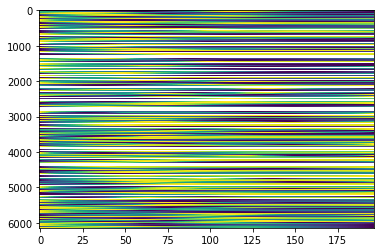

In [4]:
plt.imshow(prom_activity, aspect='auto', cmap='viridis')

In [5]:
df_pa = pd.DataFrame(prom_activity)
df_pa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6144 entries, 0 to 6143
Columns: 197 entries, 0 to 196
dtypes: float64(197)
memory usage: 9.2 MB


In [6]:
df_pa.isna().sum()

0      1038
1      1038
2      1038
3      1038
4      1038
       ... 
192    1038
193    1038
194    1038
195    1038
196    1038
Length: 197, dtype: int64

In [7]:
laplace = df_pa.dropna(axis=0)
laplace

,0,1,2,3,4,5,6,7,8,9,...,187,188,189,190,191,192,193,194,195,196
0,0.000000,0.056264,0.111195,0.164729,0.216802,0.267352,0.316316,0.363630,0.409231,0.453055,...,0.318557,0.314932,0.311317,0.307706,0.304091,0.300466,0.296825,0.293161,0.289468,0.285738
1,0.829623,0.846086,0.861820,0.876804,0.891015,0.904430,0.917027,0.928785,0.939680,0.949689,...,0.233682,0.232331,0.231286,0.230539,0.230083,0.229908,0.230006,0.230370,0.230990,0.231859
2,1.000000,0.971540,0.943509,0.915901,0.888710,0.861931,0.835559,0.809587,0.784009,0.758821,...,0.072469,0.073241,0.074110,0.075076,0.076138,0.077298,0.078554,0.079908,0.081358,0.082905
3,0.000000,0.050540,0.099978,0.148269,0.195366,0.241224,0.285797,0.329040,0.370907,0.411353,...,0.538748,0.539140,0.539576,0.540063,0.540603,0.541201,0.541862,0.542588,0.543385,0.544256
4,0.312508,0.350780,0.387973,0.424017,0.458839,0.492371,0.524540,0.555276,0.584508,0.612165,...,0.938671,0.944822,0.951114,0.957559,0.964167,0.970947,0.977910,0.985066,0.992426,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6139,1.000000,0.964438,0.929459,0.895088,0.861347,0.828263,0.795859,0.764159,0.733188,0.702969,...,0.003569,0.003141,0.002721,0.002309,0.001906,0.001511,0.001123,0.000742,0.000368,0.000000
6140,0.000000,0.027545,0.054399,0.080538,0.105936,0.130571,0.154416,0.177448,0.199642,0.220974,...,0.624511,0.608825,0.592850,0.576576,0.559993,0.543093,0.525866,0.508302,0.490391,0.472126
6141,1.000000,0.973293,0.946948,0.920973,0.895376,0.870165,0.845350,0.820937,0.796937,0.773356,...,0.002946,0.002580,0.002225,0.001880,0.001545,0.001219,0.000902,0.000594,0.000293,0.000000
6142,1.000000,0.984670,0.969445,0.954320,0.939289,0.924347,0.909489,0.894708,0.879999,0.865356,...,0.017674,0.015796,0.013899,0.011981,0.010042,0.008080,0.006096,0.004088,0.002057,0.000000


In [8]:
laplace = laplace.loc[~(laplace==0).all(axis=1)]
laplace

,0,1,2,3,4,5,6,7,8,9,...,187,188,189,190,191,192,193,194,195,196
0,0.000000,0.056264,0.111195,0.164729,0.216802,0.267352,0.316316,0.363630,0.409231,0.453055,...,0.318557,0.314932,0.311317,0.307706,0.304091,0.300466,0.296825,0.293161,0.289468,0.285738
1,0.829623,0.846086,0.861820,0.876804,0.891015,0.904430,0.917027,0.928785,0.939680,0.949689,...,0.233682,0.232331,0.231286,0.230539,0.230083,0.229908,0.230006,0.230370,0.230990,0.231859
2,1.000000,0.971540,0.943509,0.915901,0.888710,0.861931,0.835559,0.809587,0.784009,0.758821,...,0.072469,0.073241,0.074110,0.075076,0.076138,0.077298,0.078554,0.079908,0.081358,0.082905
3,0.000000,0.050540,0.099978,0.148269,0.195366,0.241224,0.285797,0.329040,0.370907,0.411353,...,0.538748,0.539140,0.539576,0.540063,0.540603,0.541201,0.541862,0.542588,0.543385,0.544256
4,0.312508,0.350780,0.387973,0.424017,0.458839,0.492371,0.524540,0.555276,0.584508,0.612165,...,0.938671,0.944822,0.951114,0.957559,0.964167,0.970947,0.977910,0.985066,0.992426,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6139,1.000000,0.964438,0.929459,0.895088,0.861347,0.828263,0.795859,0.764159,0.733188,0.702969,...,0.003569,0.003141,0.002721,0.002309,0.001906,0.001511,0.001123,0.000742,0.000368,0.000000
6140,0.000000,0.027545,0.054399,0.080538,0.105936,0.130571,0.154416,0.177448,0.199642,0.220974,...,0.624511,0.608825,0.592850,0.576576,0.559993,0.543093,0.525866,0.508302,0.490391,0.472126
6141,1.000000,0.973293,0.946948,0.920973,0.895376,0.870165,0.845350,0.820937,0.796937,0.773356,...,0.002946,0.002580,0.002225,0.001880,0.001545,0.001219,0.000902,0.000594,0.000293,0.000000
6142,1.000000,0.984670,0.969445,0.954320,0.939289,0.924347,0.909489,0.894708,0.879999,0.865356,...,0.017674,0.015796,0.013899,0.011981,0.010042,0.008080,0.006096,0.004088,0.002057,0.000000


#### Select data

In [9]:
laplace.shape

(5106, 197)

In [10]:
np_pa = laplace.to_numpy()

In [11]:
spa = np_pa[:1000]
spa.shape
plt.figure(figsize=(15,10))
#plt.plot(spa , '-');
#print(np.isnan(spa))


<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

#### Transform into timeseries type

In [12]:
X_train = TimeSeriesScalerMinMax().fit_transform(spa)
#plt.plot(X_train[:,:,0], '-');
print(X_train.shape)
print(X_train[np.isnan(X_train)].shape)
print(X_train[X_train==-np.inf].shape)
#Should be consistent with your selected data and have a 1 in the end

(1000, 197, 1)
(0,)
(0,)


#### Clusterization metrics

Euclidean k-means 2
Euclidean k-means 3
Euclidean k-means 4
Euclidean k-means 5
Euclidean k-means 6
Euclidean k-means 7
Euclidean k-means 8
Euclidean k-means 9
Euclidean k-means 10
Euclidean k-means 11
Euclidean k-means 12
Euclidean k-means 13
Euclidean k-means 14
Euclidean k-means 15
CPU times: user 3min 9s, sys: 523 ms, total: 3min 9s
Wall time: 54.7 s


Clusters      14.000000
Silhouette     0.254135
Inertia        3.600018
Name: 12, dtype: float64

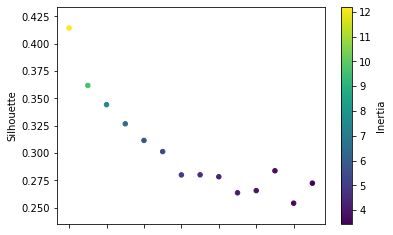

In [13]:
%%time
sz = X_train.shape[1]
seed = 0
lclusters = []
lsilscore = []
linertia = []
max_clusters = 15

for clu in range(2,max_clusters+1):
    nc = clu
    np.random.seed(seed)
    # Euclidean k-means
    print("Euclidean k-means" , clu)
    km = TimeSeriesKMeans(n_clusters=nc, random_state=seed, n_init=10)
    y_pred = km.fit_predict(X_train)
    silscore = silhouette_score(X_train, y_pred, metric="euclidean")
    iner = km.inertia_
    lclusters.append(nc)
    lsilscore.append(silscore)
    linertia.append(iner)
    
cluq = {'Clusters': lclusters, 'Silhouette':lsilscore, 'Inertia':linertia}
pd_cluq = pd.DataFrame(cluq)
pd_cluq.plot.scatter(x='Clusters',
                      y='Silhouette',
                      c='Inertia',
                      colormap='viridis');
minsil = pd_cluq['Silhouette'].idxmin()
pd_cluq.iloc[minsil,:]

#### Use the best k to cluster

In [14]:
%%time
nc = pd_cluq['Clusters'].iloc[minsil] #this should be a parameter obtained from the previous part
sz = X_train.shape[1]
seed = 0
np.random.seed(seed)
# Euclidean k-means
print("Euclidean k-means")
km = TimeSeriesKMeans(n_clusters=nc, verbose=True, random_state=seed, n_init=10)
y_pred = km.fit_predict(X_train)

Euclidean k-means
Init 1
5.151 --> 3.832 --> 3.741 --> 3.687 --> 3.644 --> 3.624 --> 3.619 --> 3.618 --> 3.617 --> 3.614 --> 3.611 --> 3.611 --> 
Init 2
5.312 --> 4.002 --> 3.892 --> 3.835 --> 3.805 --> 3.778 --> 3.746 --> 3.727 --> 3.713 --> 3.702 --> 3.691 --> 3.687 --> 3.685 --> 3.682 --> 3.682 --> 3.682 --> 
Init 3
5.412 --> 3.956 --> 3.855 --> 3.792 --> 3.753 --> 3.730 --> 3.710 --> 3.695 --> 3.687 --> 3.680 --> 3.670 --> 3.663 --> 3.662 --> 3.661 --> 3.659 --> 3.657 --> 3.656 --> 3.656 --> 3.656 --> 
Init 4
5.461 --> 3.924 --> 3.768 --> 3.712 --> 3.669 --> 3.652 --> 3.633 --> 3.617 --> 3.612 --> 3.610 --> 3.608 --> 3.607 --> 3.604 --> 3.601 --> 3.600 --> 3.600 --> 3.600 --> 3.600 --> 
Init 5
5.163 --> 3.892 --> 3.809 --> 3.772 --> 3.748 --> 3.726 --> 3.702 --> 3.688 --> 3.677 --> 3.673 --> 3.670 --> 3.670 --> 3.670 --> 3.669 --> 3.669 --> 3.669 --> 
Init 6
4.838 --> 3.840 --> 3.776 --> 3.750 --> 3.738 --> 3.728 --> 3.715 --> 3.701 --> 3.692 --> 3.689 --> 3.687 --> 3.683 --> 3.677

#### Plot your clusters

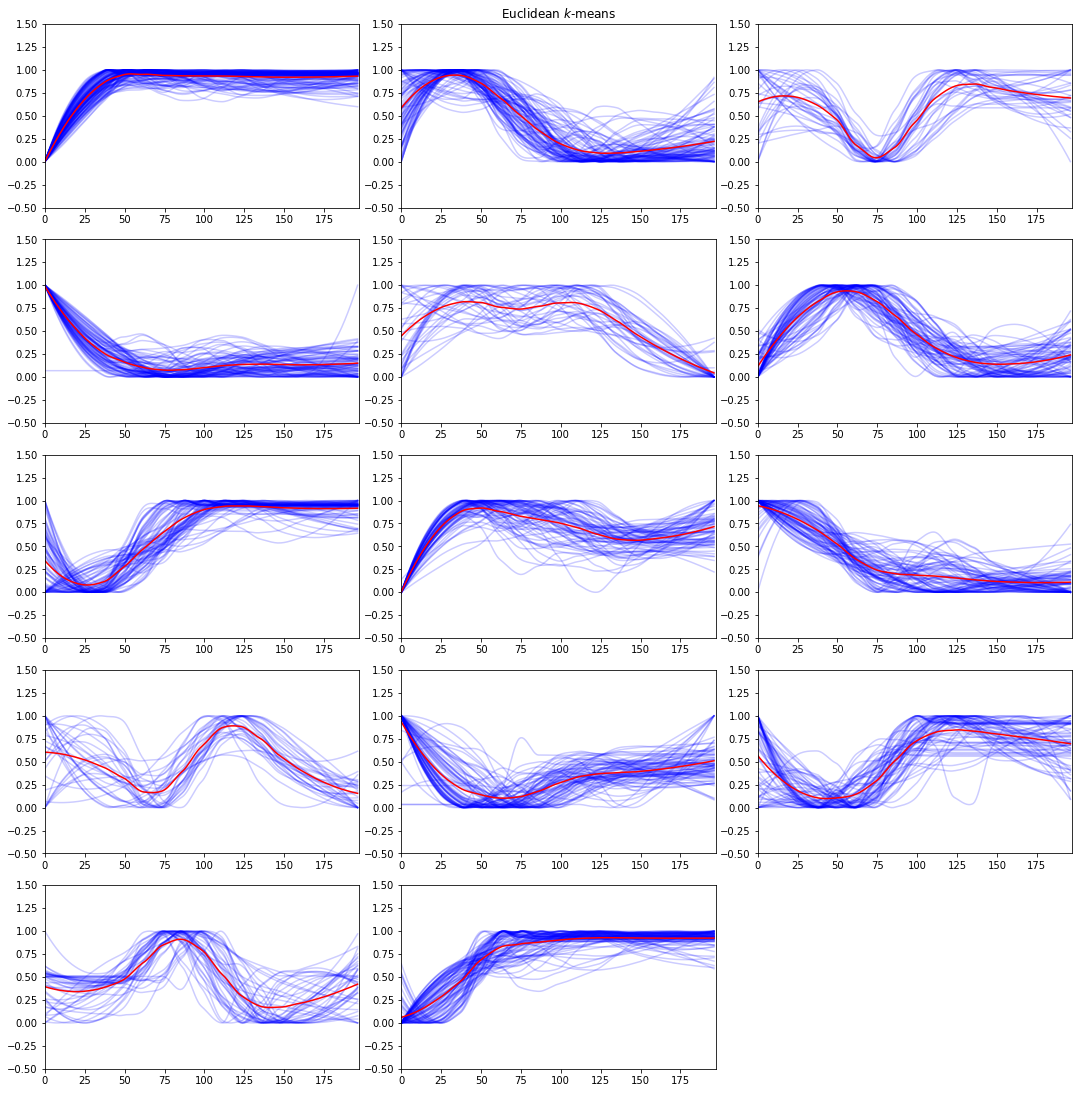

In [15]:
plt.figure(figsize=[15,30])
for yi in range(nc):
    plt.subplot(10, 3, yi + 1)
    for xx in X_train[y_pred == yi]:
        plt.plot(xx.ravel(), "b-", alpha=.2)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-0.5, 1.5)
    if yi == 1:
        plt.title("Euclidean $k$-means")
plt.tight_layout()
plt.savefig('kmclustering.png')
plt.show()

#### Save the model

In [19]:
from joblib import dump, load

In [23]:
dump(km, 'model_kmeans15_eu.joblib')

['model_kmeans15_eu.joblib']

In [24]:
kmodel = load('model_kmeans15_eu.joblib')
kmodel.predict(X_train)


array([ 1,  9,  3,  7,  2,  9, 10,  9,  3,  8,  2, 13,  4,  8, 11,  9, 11,
        9,  9, 11,  9,  4, 11,  9, 11, 11, 10,  2, 11, 11,  1,  8,  8,  3,
        4,  2,  8,  8,  3,  8,  1,  9,  9,  8,  8,  9,  4,  0,  9,  4,  4,
        8,  8,  8,  1,  8,  8,  8,  8,  8,  3,  4,  3,  8,  3,  3, 11,  8,
        8,  1,  1,  1,  4,  3, 10, 10, 10,  9,  6, 11,  2,  2, 11,  2,  8,
        8,  9, 11, 10,  3, 10,  3,  3,  4,  8,  2,  3,  8,  3,  2, 10,  4,
        3,  4,  5, 13,  5,  8,  9,  9, 11, 13, 13, 11, 13,  4,  8,  2,  8,
       13, 11,  9,  0,  7, 13,  5,  8,  4,  0,  5,  7,  4,  0,  4,  1,  7,
        7,  7,  4,  4,  7,  7,  0,  7,  7,  7,  7,  4,  0,  5,  7,  1, 13,
        1,  7,  4,  8,  1,  4,  8,  9, 13, 11,  8,  5,  1,  5,  9,  3,  9,
        3,  9, 11,  6,  9,  9, 11,  6, 11,  8,  9,  9,  9,  2, 10,  3,  8,
        3,  2,  1,  3,  2,  3, 11,  0, 11, 10,  6, 10,  3,  1, 10,  7, 10,
        3,  6,  6, 10,  4,  3,  8, 10,  3,  6,  6, 13,  2,  6, 10, 11,  3,
        8,  8,  1,  1,  1

#### Done! now lets get information from the clusters